In [1]:
# Import the necessary libraries
import os
import sys

SCRIPT_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat, savemat
from scipy.optimize import curve_fit, minimize
import scipy.signal as sig
import control as ct
from control.matlab import tf, ss, lsim, bode, c2d
from scipy.io import loadmat, savemat
from utils.ce_drive_get_params import isstable, simulate_model
from utils.ce_drive_data_utils import generate_trajectory, generate_trajectory_param_pairs_ce_drive, \
    generate_normal, compute_actual_tf, generate_uniform
from utils.plot_utils import plot_trajectories
import json
import torch
import os
import torch
from torch import nn
from torch.autograd import Variable
from src.rnn_models import RNN_model, push_model

In [2]:
# Import dataset
data_prbs_signal = loadmat('../data/coupled_drive/DATAPRBS.MAT')
data_uniform_signal = loadmat('../data/coupled_drive/DATAUNIF.MAT')

In [3]:
z1, z2, z3 = data_prbs_signal['z1'], data_prbs_signal['z2'], data_prbs_signal['z3']
u1, u2, u3 = data_prbs_signal['u1'], data_prbs_signal['u2'], data_prbs_signal['u3']

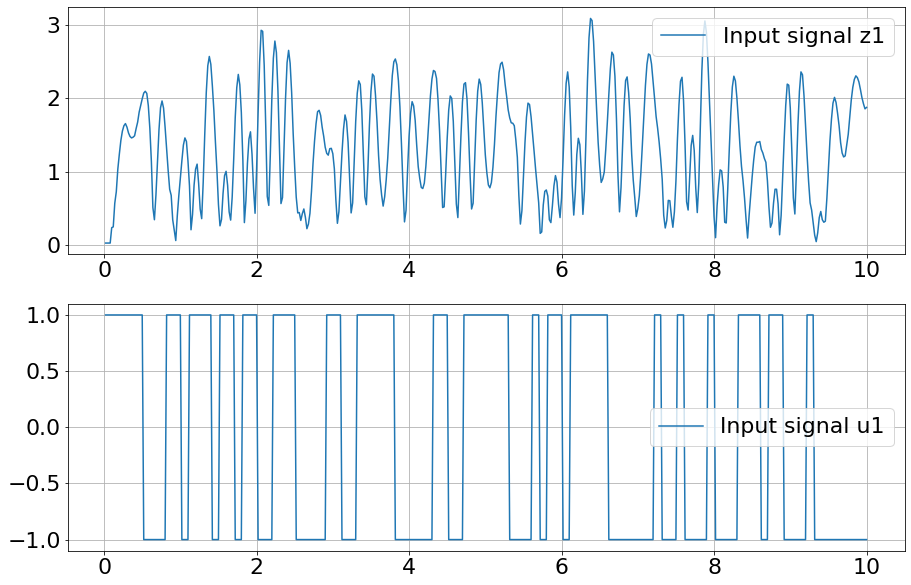

In [4]:
# Plot one of the datasets
Ts = 20e-3
N = 500
t = np.linspace(1, N, N)
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 22})
plt.subplot(211)
plt.plot(t*Ts, z1, label='Input signal z1')
plt.grid()
plt.legend()
plt.subplot(212)
plt.plot(t*Ts, u1, label='Input signal u1')
plt.grid()
plt.legend()
plt.show()

In [5]:
# Possible model - 1 (table 3, second row)
a = 5163
b = -19.93
c = -509.8
d = -2835

In [6]:
s = tf('s')
G = a/(s**3 -b*s**2 - c*s -d)

In [7]:
def get_actual_params(a, b, c, d):
    k = -a/d
    alpha = -real_poles
    omega0 = np.sqrt(-d/alpha)
    xi = (-b - alpha)/(2*omega0)
    return k, alpha, omega0, xi

In [8]:
# Getting the parameters
poles = np.roots(np.array([1, 19.93, 509.8, 2835]))
real_poles = (np.real(poles[np.isreal(poles)])).item()

k, alpha, omega0, xi = get_actual_params(a, b, c, d)


In [9]:
print("k:{:.3f}, alpha:{:.3f}, omega0:{:.3f}, xi:{:.3f}".format(k, alpha, omega0, xi))

k:1.821, alpha:6.735, omega0:20.517, xi:0.322


In [10]:
# Make the transfer function H(s)
Hs = (k*alpha*omega0**2)/((s+alpha)*(s**2 + 2*xi*omega0*s + omega0**2))
print(Hs)


              5163
--------------------------------
s^3 + 19.93 s^2 + 509.8 s + 2835



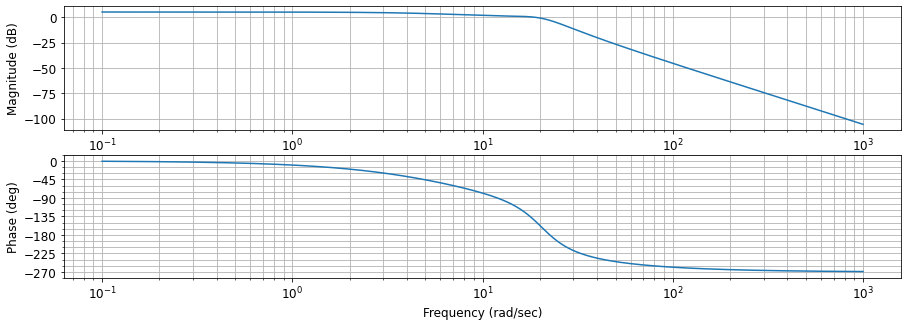

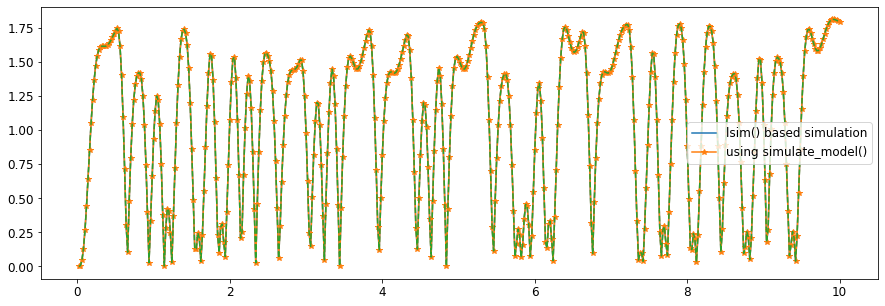

In [11]:
# Simulate the model Gs
plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 12})
bode(G)
plt.show()
plt.figure(figsize=(15, 5))
t_arr = t*Ts
y_model, T, xout = lsim(sys=ss(G), U=u1, T=np.linspace(1,500,500)*Ts)
y_model = np.abs(y_model)
y_model_2 = simulate_model(ss(G), u=u1.reshape((-1, 1)), t_arr=t_arr)
plt.plot(t_arr, y_model)
plt.plot(t_arr, np.abs(y_model), '-*')
plt.plot(t_arr, y_model_2, "--")
plt.legend(['lsim() based simulation', 'using simulate_model()'])
plt.show()

y_model = np.abs(y_model)

[[ 0.000e+00  1.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00]
 [-2.835e+03 -5.098e+02 -1.993e+01]] [[   0]
 [   0]
 [5163]] [1 0 0]
(500,)


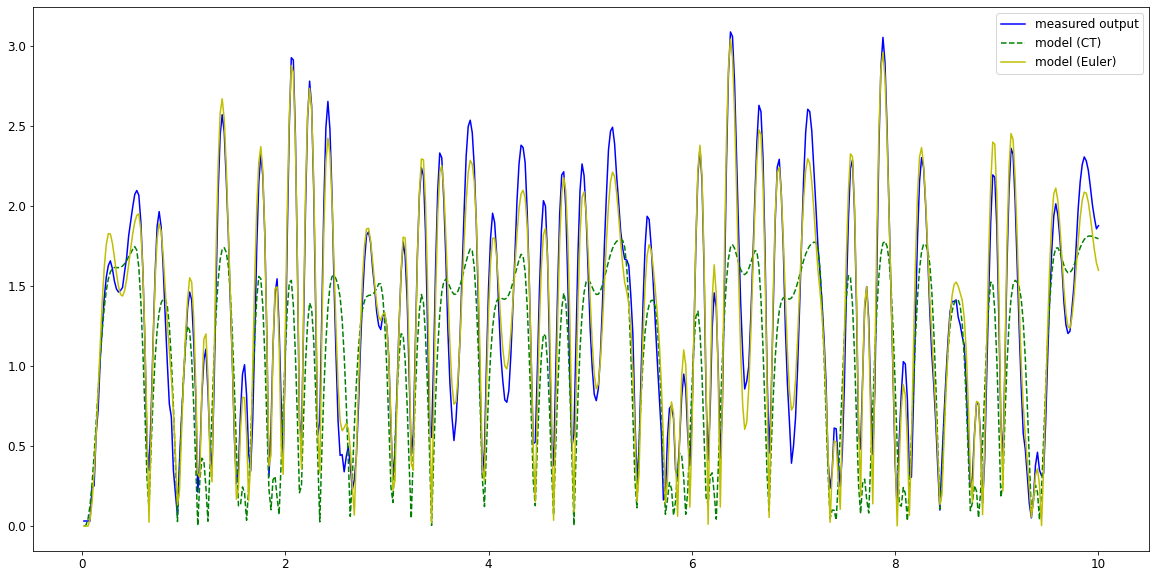

In [12]:
# simulation with euler discretization
A = np.array([[0,1,0],
              [0,0,1],
              [d,c,b]])

B = np.array([[0], [0], [a]])
C = np.array([1, 0, 0])
print(A, B, C)
A_euler = np.eye(3) + Ts*A;
B_euler = Ts*B;
C_euler = C;

# construct Euler discretized state space 
model_euler = ss(A_euler, B_euler, C_euler, 0, 1)
print(lsim(model_euler, u1.reshape((-1,)))[0].shape)
y_model_euler = np.abs(lsim(model_euler, u1.reshape((-1,)))[0]);
plt.figure(figsize=(20,10))
#plt.subplot(2,1,1)
plt.plot(t*Ts, z1,'b')
#plt.legend(['measured output'])
#plt.subplot(2,1,2)
plt.plot(t*Ts, y_model,'g--')
plt.plot(t*Ts, y_model_euler,'y')
plt.legend(['measured output','model (CT)', 'model (Euler)'])

In [13]:
Hs2 = compute_actual_tf(k=k, alpha=alpha, omega0=omega0, xi=xi)
print(type(Hs2))
print(Hs2)

<class 'control.xferfcn.TransferFunction'>

              5163
--------------------------------
s^3 + 19.93 s^2 + 509.8 s + 2835



In [14]:
sig.TransferFunction(a, [1, -b, -c, -d])

TransferFunctionContinuous(
array([5163.]),
array([1.000e+00, 1.993e+01, 5.098e+02, 2.835e+03]),
dt: None
)

In [15]:
from scipy import signal as sig

def simulate_model(x, a, b, c, d):
    tf = sig.TransferFunction([a], [1, -b, -c, -d])
    N = len(x)
    t_arr = np.linspace(1, N, N)*20e-3
    to, yo, xo = sig.lsim2(tf, U=x, T=t_arr)
    yo = np.abs(yo)
    return yo
    
def identify_model(t, input_signal, output_signal, method='lm', p0=None, bounds=None):
    
    kwargs = {"epsfcn":1e-9}
    if not p0 is None:
        params, params_cov = curve_fit(simulate_model, xdata=input_signal, ydata=output_signal,
                                       method=method, p0=p0, **kwargs)
    else:
        params, params_cov = curve_fit(simulate_model, xdata=input_signal, ydata=output_signal,
                                        method=method)

    return {'a': params[0], 'b': params[1], 'c': params[2], 'd': params[3]}, params_cov

In [16]:
#params_estimate = [1.821, 6.735, 20.517, 0.322]
params_estimate = [a, b, c, d]
print(params_estimate)

[5163, -19.93, -509.8, -2835]


In [17]:
def initialize_p0(params_estimate, percent_=0.2):
    # Percentage within mean (+ or - percent_ %) parameter
    eps = np.finfo(float).eps # Get the machine epsilon 
    theta_1 = generate_uniform(N=1, a=params_estimate[0] * (1-percent_), b=params_estimate[0] * (1+percent_)) # Parameter k
    theta_2 = generate_uniform(N=1, a=params_estimate[1] * (1-percent_), b=params_estimate[1]  * (1+percent_)) # Parameter \alpha
    theta_3 = generate_uniform(N=1, a=params_estimate[2] * (1-percent_), b=params_estimate[2]  * (1+percent_)) # Parameter \omega0
    theta_4 = generate_uniform(N=1, a=params_estimate[3] * (1-percent_), b=params_estimate[3]  * (1+percent_)) # Parameter \xi
    #theta_5 = generate_uniform(N=1, a=eps, b=0.01) # Parameter wn_variance (assuming noise is zero-mean)

    theta_vector = [theta_1,
                    theta_2,
                    theta_3,
                    theta_4]

    return theta_vector

In [18]:
p0 = initialize_p0(params_estimate=params_estimate, percent_=0.0)

In [19]:
print(p0)

[5163.0, -19.93, -509.8, -2835.0]


In [20]:
u1.shape, z1.shape, t_arr.shape

((500, 1), (500, 1), (500,))

In [21]:
#param_bounds = ([1.0, 0.0, 0.0, 0.0], [np.inf, np.inf, np.inf, np.inf])
params_opt, params_cov_opt =  identify_model(t=t_arr, input_signal=u1.reshape((-1,)), 
                                             output_signal=z1.reshape((-1,)), method='lm', p0=p0)

k_opt, alpha_opt, omega0_opt, xi_opt = get_actual_params(**params_opt)

print("'True' parameters")
print("k:{:.3f}, alpha:{:.3f}, omega0:{:.3f}, xi:{:.3f}".format(k, alpha, omega0, xi))
print("Obtained optimized params: (k, alpha, omega, xi) ")
print([k_opt, alpha_opt, omega0_opt, xi_opt])
print("Variances for the parameters:")
print(np.sqrt(np.diag(params_cov_opt)))

'True' parameters
k:1.821, alpha:6.735, omega0:20.517, xi:0.322
Obtained optimized params: (k, alpha, omega, xi) 
[2.057110763094539, 6.735066686013923, 17.487159102416552, 0.09557499928836284]
Variances for the parameters:
[71.83334844  0.21844621  2.3286741  46.36434298]


In [29]:
params_estimate

[5163, -19.93, -509.8, -2835]

In [22]:
def get_optimized_params(t_arr, u1, z1, params_estimate):
    
    p0 = initialize_p0(params_estimate=params_estimate, percent_=0.0)
    #param_bounds = ([1.0, 0.0, 0.0, 0.0], [np.inf, np.inf, np.inf, np.inf])
    params_opt, params_cov_opt =  identify_model(t=t_arr, input_signal=u1.reshape((-1,)), 
                                                 output_signal=z1.reshape((-1,)), method='lm', p0=p0)

    k_opt, alpha_opt, omega0_opt, xi_opt = get_actual_params(**params_opt)

    print("'True' parameters")
    print("k:{:.3f}, alpha:{:.3f}, omega0:{:.3f}, xi:{:.3f}".format(k, alpha, omega0, xi))
    print("Obtained optimized params: (k, alpha, omega, xi) ")
    print([k_opt, alpha_opt, omega0_opt, xi_opt])
    print("Variances for the parameters:")
    print(np.sqrt(np.diag(params_cov_opt)))
    return [k_opt, alpha_opt, omega0_opt, xi_opt], params_opt

In [23]:
tf_params_opt, params_opt = get_optimized_params(t_arr=t_arr, u1=u1, z1=z1, params_estimate=params_estimate)

'True' parameters
k:1.821, alpha:6.735, omega0:20.517, xi:0.322
Obtained optimized params: (k, alpha, omega, xi) 
[2.057110763094539, 6.735066686013923, 17.487159102416552, 0.09557499928836284]
Variances for the parameters:
[71.83334844  0.21844621  2.3286741  46.36434298]


In [24]:
tf_params_opt

[2.057110763094539, 6.735066686013923, 17.487159102416552, 0.09557499928836284]

In [25]:
params_opt

{'a': 4236.801326482269,
 'b': -10.077737123551822,
 'c': -410.17564836697886,
 'd': -2059.5883325741747}

MATLAB

ans =

   1.0e+03 *

    4.6889   -0.0105   -0.4328   -2.3532

In [26]:
Hs_opt = sig.TransferFunction(params_opt["a"], [1, -params_opt["b"], -params_opt["c"], -params_opt["d"]])
y_model_brute_force_optim = np.abs(sig.lsim2(Hs_opt, u1.reshape((-1, 1)), t_arr)[1])

In [ ]:
#y_model_brute_force_optim = simulate_model(compute_actual_tf(k=k_opt,
#                                                             alpha=alpha_opt,
#                                                             omega0=omega0_opt,
#                                                             xi=xi_opt), 
#                                           u=u1.reshape((-1, 1)), t_arr=t_arr)

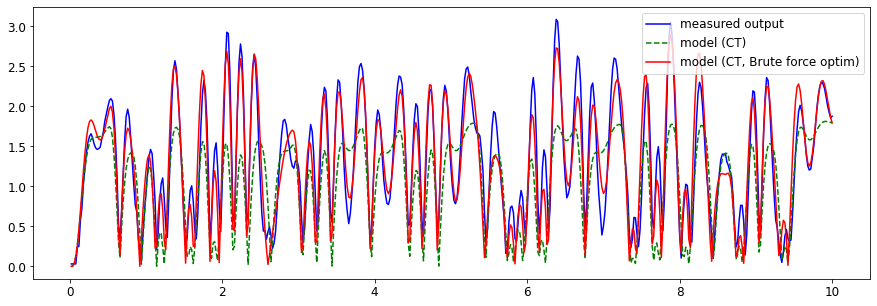

In [27]:
plt.figure(figsize=(15,5))
#plt.subplot(2,1,1)
plt.plot(t*Ts, z1,'b')
#plt.legend(['measured output'])
#plt.subplot(2,1,2)
plt.plot(t*Ts, y_model,'g--')
plt.plot(t*Ts, simulate_model(u1, **params_opt), 'r')
plt.legend(['measured output','model (CT)', 'model (CT, Brute force optim)'])
#plt.savefig('./brute_force_optimization.pdf')
plt.show()

In [28]:
MSE_before_optimization = scipy.linalg.norm(z1.reshape((-1, 1)) - y_model.reshape((-1, 1)))**2
MSE_after_optimization = scipy.linalg.norm(z1.reshape((-1, 1)) - y_model_brute_force_optim.reshape((-1, 1)))**2
MSE_for_Euler_method = scipy.linalg.norm(z1.reshape((-1, 1)) - y_model_euler.reshape((-1, 1)))**2

print("MSE values:")
print("Before optimization: {}".format(MSE_before_optimization))
print("For Euler method: {}".format(MSE_for_Euler_method))
print("After brute force optimization: {}".format(MSE_after_optimization))

MSE values:
Before optimization: 154.84194631473486
For Euler method: 13.660232496366127
After brute force optimization: 38.8443054660244


In [88]:
#def cost_function(parameters):
    # my_model is a continuous time transfer function, simulate_model also simulates in continuous time,
    # Parameters are unconstrained, no nose considered
    # Idea: How good can this model structure ? 
    # Input signal and Output signal are from original dataset
    # Model_output = simulate_model(my_model(parameters), input_signal)
    # J = cost(Model_output, output_signal) #where J = MSELoss()
    # minimize the cost 